## Praca domowa 6
### Wstęp do uczenia maszynowego
### Paweł Morgen

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Wczytanie danych oraz eksploracja

In [3]:
df = pd.read_csv("clustering_R3.csv")
df.columns = ["x", "y", "z"]
df.describe()

,x,y,z
count,1000.000000,1000.000000,1000.000000
mean,240.181036,154.937365,5.454947
std,115.556334,41.964161,4.793973
min,38.516347,87.376621,0.125057
25%,148.801776,104.853322,1.806255
50%,231.754437,151.846118,3.430892
75%,350.277958,198.367658,8.287805
max,399.930758,213.917568,24.537806


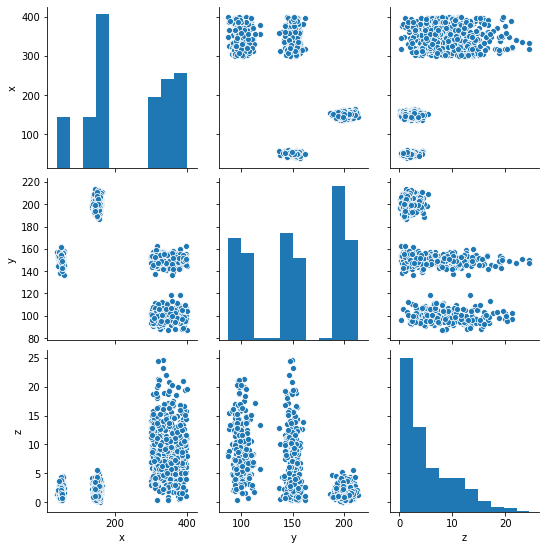

In [4]:
sns.pairplot(df)

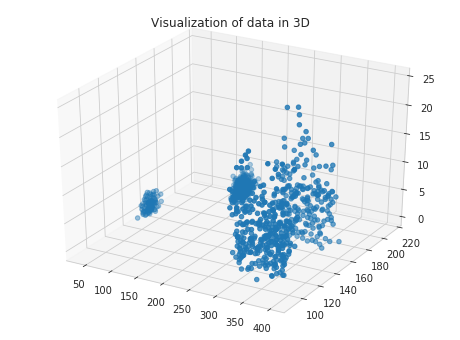

In [15]:
fig = plt.figure(num=None, figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.loc[:,"x"].to_numpy(), df.loc[:,"y"].to_numpy(), df.loc[:,"z"].to_numpy())
ax.set_title("Visualization of data in 3D")
plt.show()

Widzimy jeden mały, odstający klaster oraz sporą chmurę punktów gotowych do dalszego podziału.

### Wybór metod klasteryzacyjnych

Przekonajmy się, jak z danymi poradzą sobie algorytmy `AgglomerativeClustering` z miarą dystansu Warda oraz `GaussianMixture`.

### Określenie optymalnej ilości klastrów

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
max_k = 20
results_k = np.ndarray((max_k - 1,6))
for k in range(2,max_k + 1):
    cls = [AgglomerativeClustering(n_clusters = k, linkage = 'ward'),
           GaussianMixture(n_components = k)]
    for i in range(2):
        cl = cls[i]
        labels = cl.fit_predict(df_scaled)
        db = davies_bouldin_score(df_scaled, labels)
        sil = silhouette_score(df_scaled, labels)
        ch = calinski_harabasz_score(df_scaled, labels)
        results_k[k-2][[3 * i, 3* i + 1, 3 * i + 2]] = [db, sil, ch]

results_pd = pd.DataFrame(data = results_k)
results_pd.columns = ["ward_0", "ward_1", "ward_2", "gm_0", "gm_1", "gm_2"]
results_pd["id"] = results_pd.index
results_pd["k"] = pd.Series(np.array(range(2, max_k + 1)), dtype='int')
cols = ['ward', 'gm']
df1 = pd.wide_to_long(results_pd, stubnames = cols, i = 'id', j = 'metric', sep = '_').reset_index(level = 'metric').reset_index(drop = True).melt(id_vars = ['metric', 'k'], var_name = 'algoritm')
df1 = df1.assign(metric = np.array(['davies_bouldin', 'silhouette', 'calinski_harabasz'])[df1.loc[:,'metric']])


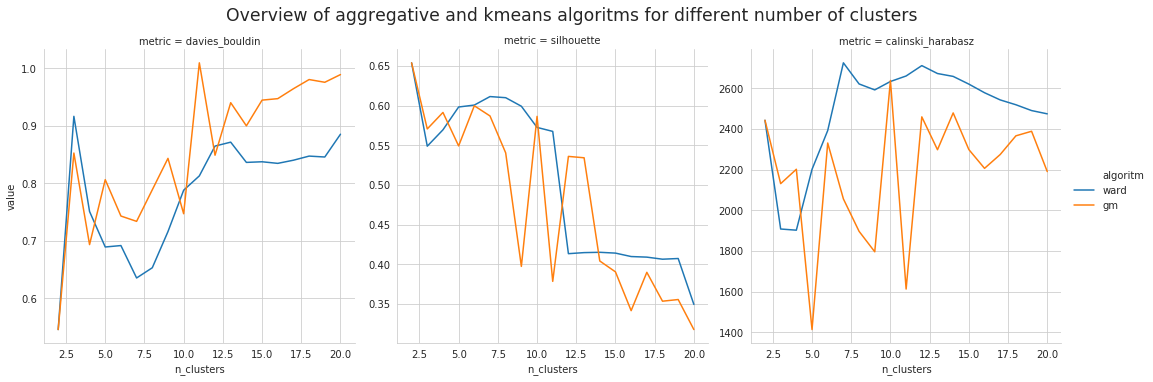

In [7]:
sns.set_style('whitegrid')
ax = sns.relplot(x = 'k', y = 'value', data = df1, hue = 'algoritm', col = 'metric', kind = 'line', facet_kws = {'sharey': False})
ax.set(xlabel = 'n_clusters')
ax.fig.suptitle("Overview of aggregative and kmeans algoritms for different number of clusters", y = 1.05, fontsize = 'xx-large')
plt.show()

### Opis metryk oraz analiza wyników

Zastosowano 3 metryki: indeks Daviesa-Bouldina, współczynnik Silhouette oraz indeks Calińskiego-Harabasza.

Indeks Daviesa-Bouldina opisuje, jak dobrze klastry są od siebie odseparowane. Wartość **najmniejszą** interpretujemy jako **optymalną** (najlepszą).

Współczynnik Silhouette jest uśrednioną dla każdego punktu wartością opisującą, *jak dobrze* dany punkt pasuje do swojego klastra, a *jak źle* do innych. Promuje klastry, w których punkty są ciasno upakowane. Wartość **największą** interpretujemy jako **optymalną**.

Indeks Calińskiego-Harabasza porównuje rozrzut punktów w klastrach do rozrzutu punktów między klastrami. Wartość **największą** interpretujemy jako **optymalną**.

Widzimy, że - ogólnie rzacz ujmując - lepiej sobie radzi `AgglomerativeClustering`. 

Co do ilości klastrów, mamy dwie możliwości do rozważenia. Jedna to **2** - widać to było nawet gołym okiem. Jednak takie rozwiązanie wydaje się zbyt ogólne (co jest obrazowane przez nie najwyższą wartość indeksu Calińskiego-Harabasza). Wobec tego skłaniałbym się ku drugiej opcji, czyli **7** klastrów. Dla tej wartości maksymalizujemy wartość indeksu Calińskiego-Harabasza, natomiast w pozstałych metrykach jest to druga najlepsza wartość (po tej dla 2). Co istotne, to rozwiązanie jest *uogólnieniem* rozwiązania z dwoma klastrami - punkty należące do *odsuniętego* klastra przy podziale na 7 klastrów nadal tworzą jeden, spójny klaster.

### Wizualizacja wyników

In [8]:
# Inicjalizacja algorytmów
ward_final = AgglomerativeClustering(7, linkage = 'ward')
gm_final = GaussianMixture(7)
new_df = df.copy()
new_df["labels_0"] = ward_final.fit_predict(df_scaled)
new_df["labels_1"] = gm_final.fit_predict(df_scaled)
new_df["id"] = new_df.index
new_df = pd.wide_to_long(new_df, "labels", i = "id", j = 'algoritm', sep = "_").reset_index(level = 'algoritm').reset_index(drop = True)
final_df = new_df.assign(algoritm = np.array(["ward", "gm"])[new_df.loc[:,"algoritm"]])
final_df["labels"] = pd.Series(final_df["labels"], dtype = "category")

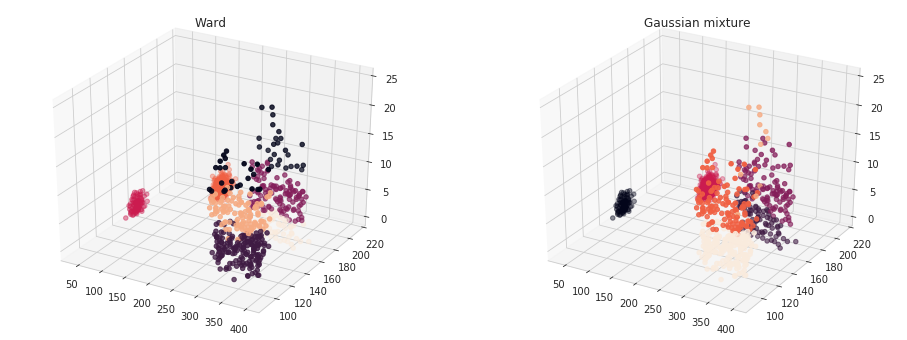

In [11]:
fig = plt.figure(num=None, figsize=(16, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(final_df.loc[final_df.loc[:,'algoritm'] == 'ward',"x"], 
           final_df.loc[final_df.loc[:,'algoritm'] == 'ward',"y"], 
           final_df.loc[final_df.loc[:,'algoritm'] == 'ward',"z"],
          c = final_df.loc[final_df.loc[:,'algoritm'] == 'ward',"labels"])
ax.set_title('Ward')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(final_df.loc[final_df.loc[:,'algoritm'] == 'gm',"x"], 
           final_df.loc[final_df.loc[:,'algoritm'] == 'gm',"y"], 
           final_df.loc[final_df.loc[:,'algoritm'] == 'gm',"z"],
          c = final_df.loc[final_df.loc[:,'algoritm'] == 'gm',"labels"])
ax.set_title('Gaussian mixture')
plt.show()